In [40]:
# Step 1.0 - Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


# Make plots look clean
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

In [41]:
import warnings
warnings.filterwarnings("ignore")

In [42]:
data = pd.read_csv("RTA Dataset.csv")

#STEP 1.2 first 5 rows
print("FIRST 5 ROWS OF THE DATASET:")
display(data.head())

FIRST 5 ROWS OF THE DATASET:


,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


In [43]:
# STEP 1.3 — Show column names
print("\nCOLUMN NAMES:")
print(list(data.columns))


COLUMN NAMES:
['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level', 'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment', 'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions', 'Light_conditions', 'Weather_conditions', 'Type_of_collision', 'Number_of_vehicles_involved', 'Number_of_casualties', 'Vehicle_movement', 'Casualty_class', 'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity', 'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement', 'Cause_of_accident', 'Accident_severity']


In [44]:
# STEP 1.4 — Dataset shape (rows, columns)
print("\nDATASET SHAPE:")
print(data.shape)


DATASET SHAPE:
(12316, 32)


In [45]:
# STEP 1.5 — Check missing values
print("\nMISSING VALUES SUMMARY:")
missing_summary = data.isna().sum().sort_values(ascending=False)
print(missing_summary.head(20))


MISSING VALUES SUMMARY:
Defect_of_vehicle          4427
Service_year_of_vehicle    3928
Work_of_casuality          3198
Fitness_of_casuality       2635
Type_of_vehicle             950
Types_of_Junction           887
Driving_experience          829
Educational_level           741
Vehicle_driver_relation     579
Owner_of_vehicle            482
Lanes_or_Medians            385
Vehicle_movement            308
Area_accident_occured       239
Road_surface_type           172
Type_of_collision           155
Road_allignment             142
Casualty_class                0
Pedestrian_movement           0
Cause_of_accident             0
Casualty_severity             0
dtype: int64


In [46]:
# STEP 1.6 — Check the target variable distribution
print("\nACCIDENT SEVERITY DISTRIBUTION:")
print(data["Accident_severity"].value_counts())


ACCIDENT SEVERITY DISTRIBUTION:
Accident_severity
Slight Injury     10415
Serious Injury     1743
Fatal injury        158
Name: count, dtype: int64


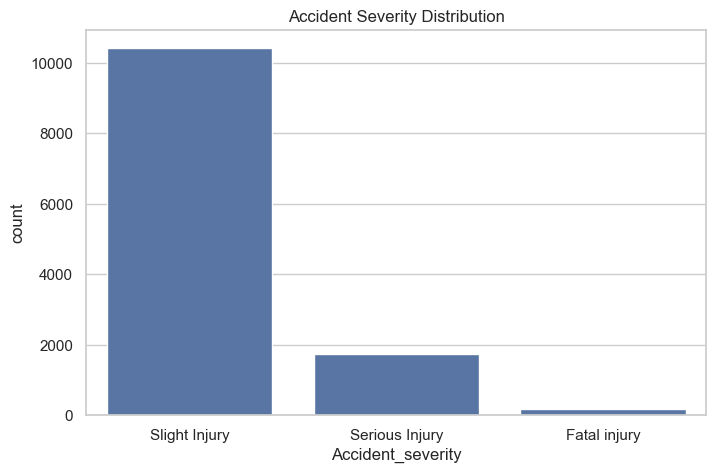

In [47]:
# Plot distribution
sns.countplot(x="Accident_severity", data=data)
plt.title("Accident Severity Distribution")
plt.show()

In [48]:
# ======================================================
# STEP 2 — DROP COLUMNS NOT NEEDED FOR MODEL
# Many casualty fields apply only when injuries occur.
# They introduce noise & have too many missing values.
# ======================================================

drop_columns = [
    'Work_of_casuality',
    'Fitness_of_casuality',
    'Sex_of_casuality',
    'Age_band_of_casualty',
    'Casualty_class',
    'Pedestrian_movement'  # optional
]

for col in drop_columns:
    if col in data.columns:
        data = data.drop(col, axis=1)

print("Shape after dropping irrelevant columns:", data.shape)


Shape after dropping irrelevant columns: (12316, 27)


In [49]:
# ======================================================
# STEP 3 — HANDLE MISSING VALUES
# Strategy:
# - Categorical features → replace NA with "Unknown"
# - Time → converted to hour
# ======================================================

# Fill categorical missing values with "Unknown"
data = data.fillna("Unknown")

# Convert Time → hour of day
def extract_hour(x):
    try:
        return int(x.split(':')[0])
    except:
        return 0

data["Hour"] = data["Time"].apply(extract_hour)

# Drop the original time column
data = data.drop("Time", axis=1)

print("Missing values after cleaning:")
print(data.isna().sum().sum())  # Should be 0


Missing values after cleaning:
0


In [50]:
# ======================================================
# STEP 4 — LABEL ENCODE THE TARGET
# Accident_severity is categorical → convert to numbers
# ======================================================

label = LabelEncoder()
data["Accident_severity"] = label.fit_transform(data["Accident_severity"])

print("Encoding of target variable:")
print(dict(zip(label.classes_, label.transform(label.classes_))))


Encoding of target variable:
{'Fatal injury': 0, 'Serious Injury': 1, 'Slight Injury': 2}


In [51]:
# ======================================================
# STEP 5 — ONE-HOT ENCODE ALL CATEGORICAL FEATURES
# ======================================================

X = data.drop("Accident_severity", axis=1)
y = data["Accident_severity"]

# Convert all categorical columns to one-hot
X = pd.get_dummies(X, drop_first=True)

print("Final input shape:", X.shape)


Final input shape: (12316, 159)


In [52]:
# ======================================================
# STEP 6 — TRAIN–TEST SPLIT
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# ======================================================
# STEP 7 — SCALE FEATURES
# ======================================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [53]:
# ======================================================
# STEP 8 — BUILD THE NEURAL NETWORK
# Architecture chosen for accuracy + stability
# ======================================================

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 accident severity classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,915 (120.76 KB)

 Trainable params: 30,915 (120.76 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# ======================================================
# STEP 9 — TRAIN MODEL
# ======================================================
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8432 - loss: 0.5240 - val_accuracy: 0.8422 - val_loss: 0.4864
Epoch 2/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8465 - loss: 0.4724 - val_accuracy: 0.8422 - val_loss: 0.4896
Epoch 3/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8463 - loss: 0.4530 - val_accuracy: 0.8422 - val_loss: 0.4851
Epoch 4/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8463 - loss: 0.4411 - val_accuracy: 0.8422 - val_loss: 0.4867
Epoch 5/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8462 - loss: 0.4265 - val_accuracy: 0.8407 - val_loss: 0.4919
Epoch 6/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8468 - loss: 0.4189 - val_accuracy: 0.8422 - val_loss: 0.4914
Epoch 7/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8482 - loss: 0.4065 - val_accuracy: 0.8427 - val_loss: 0.5032
Epoch 8/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8470 - loss: 0.3947 - val_accuracy: 0.

In [55]:
# ======================================================
# STEP 10 — MODEL EVALUATION
# ======================================================
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8231 - loss: 0.6167
Test Accuracy: 0.823051929473877


In [56]:
# ======================================================
# STEP 11 — CONFUSION MATRIX & REPORT
# ======================================================
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.31      0.11      0.17       349
           2       0.85      0.95      0.90      2084

    accuracy                           0.82      2464
   macro avg       0.39      0.36      0.36      2464
weighted avg       0.77      0.82      0.79      2464


Confusion Matrix:
[[   0    2   29]
 [   0   40  309]
 [   8   88 1988]]


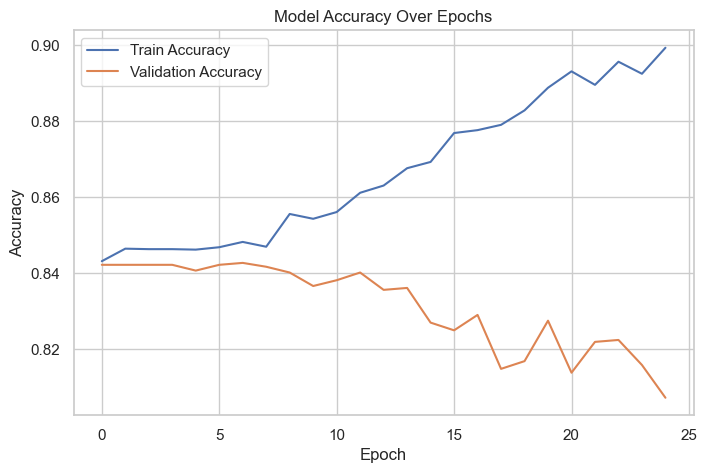

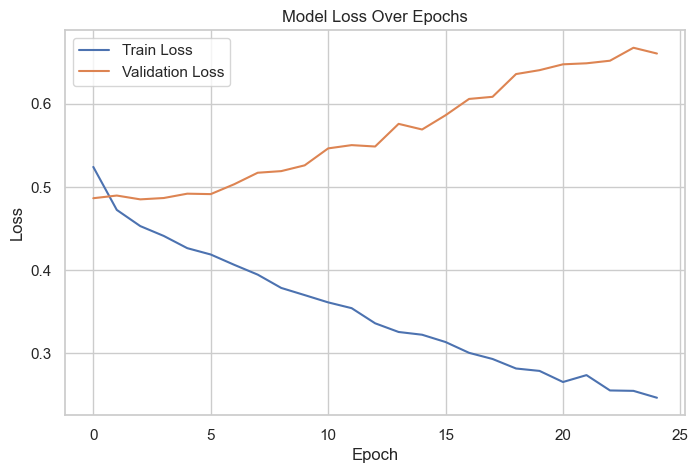

In [57]:
# ======================================================
# STEP 12 — TRAINING CURVE PLOTS
# ======================================================
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
